In [364]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
import sys
import os
import cv2
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import faiss
from tqdm import tqdm, tqdm_notebook

In [366]:
# from keras.applications.resnet50 import ResNet50
# from keras.preprocessing import image
# from keras.applications.resnet50 import preprocess_input, decode_predictions

## 102 Flowers

In [367]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import losses
from keras import regularizers
from keras import backend as K
import tensorflow as tf

In [368]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [369]:
def wfile(root):
    img_fps = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            img_fps.append(os.path.join(path, name))

    return sorted(img_fps)

In [427]:
ROOT_DATA = "Path_to_your_flowers_dataset"
TRAIN_FD = os.path.join(ROOT_DATA, "train")
VAL_FD = os.path.join(ROOT_DATA, "valid")
TEST_FD = os.path.join(ROOT_DATA, "test")
SALIENCY_PATH = "Path_to_your_saliency"

In [371]:
train_img_fps = wfile(TRAIN_FD)
val_img_fps = wfile(VAL_FD)
test_img_fps = wfile(TEST_FD)

In [372]:
train_labels = np.array([int(img_fp.split("/")[-2]) for img_fp in train_img_fps])
val_labels = np.array([int(img_fp.split("/")[-2]) for img_fp in val_img_fps])
test_labels = np.array([int(img_fp.split("/")[-2]) for img_fp in test_img_fps])

## Saliency Prediction

In [373]:
sys.path.insert(0, SALIENCY_PATH)

In [374]:
from main import test_model, define_paths

In [375]:
img_fp = random.choice(test_img_fps)

In [376]:
class Args:
    data = 'salicon'
    path = img_fp
    phase = 'test'
args = Args()

In [377]:
paths = define_paths(SALIENCY_PATH, args)

In [378]:
map_fp = test_model("salicon", paths, "gpu")[0]

>> Start testing with SALICON gpu model...


In [379]:
img_arr = cv2.imread(img_fp)[:, :, ::-1]
map_arr = cv2.imread(map_fp, 0)

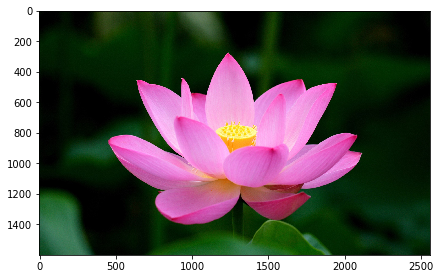

In [380]:
original_image = cv2.imread(img_fp)[:, :, ::-1]
plt.imshow(img_arr)

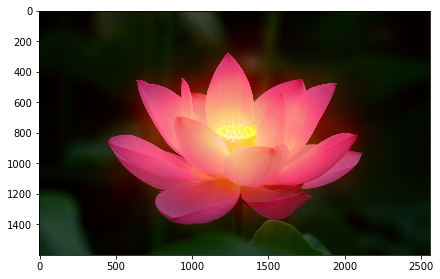

In [381]:
plt.imshow(img_arr)
plt.imshow(map_arr, cmap='hot', alpha=0.45)

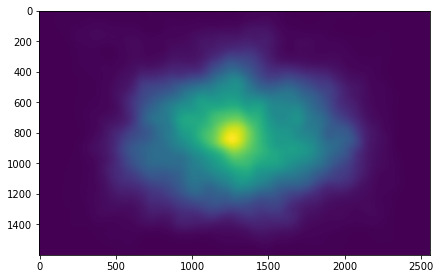

In [382]:
plt.imshow(map_arr)

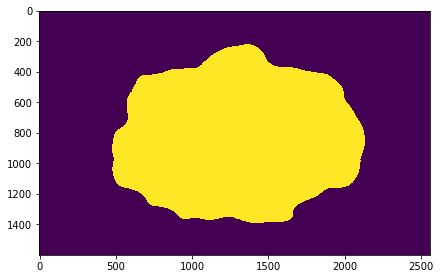

In [383]:
map_img = copy.deepcopy(map_arr)
map_img = map_img / 255
map_img = map_img.astype(np.float32)

thres = 0.09
map_img[map_img >= thres] = 1
map_img[map_img < thres] = 0

plt.imshow(map_img);

In [384]:
# crop bbox
horizontal_indicies = np.where(np.any(map_img, axis=0))[0]
vertical_indicies = np.where(np.any(map_img, axis=1))[0]

In [385]:
if horizontal_indicies.shape[0]:
    x1, x2 = horizontal_indicies[[0, -1]]
    y1, y2 = vertical_indicies[[0, -1]]
    # x2 and y2 should not be part of the box. Increment by 1.
    x2 += 1
    y2 += 1
else:
    # No mask for this instance. Might happen due to
    # resizing or cropping. Set bbox to zeros
    x1, x2, y1, y2 = 0, 0, 0, 0

In [386]:
img_arr_2 = copy.deepcopy(img_arr)

In [428]:
cv2.rectangle(img_arr_2, (x1, y1), (x2, y2), (255,225,0), 2);

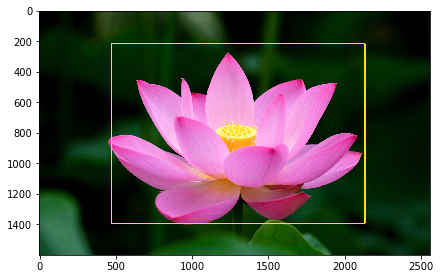

In [429]:
plt.imshow(img_arr_2);

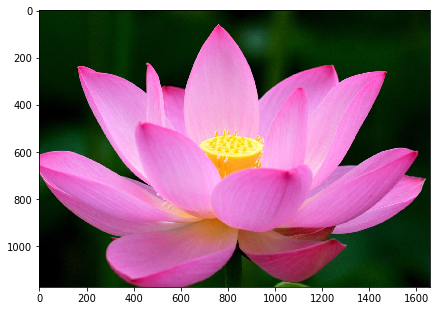

In [389]:
sal_crop = img_arr[y1:y2, x1:x2]
plt.imshow(sal_crop)

## Faiss Image Retrieval


In [390]:
id2img_fps = dict(enumerate(train_img_fps))

In [391]:
ROOT_FD = "./"

## Model

In [392]:
def img_preprocess(img_fp, img_size=(384, 384), expand=True):
#     img = cv2.imread(img_fp)[:, :, ::-1]
    img = cv2.resize(img_fp, img_size)

    # normalize image
    img = norm_mean_std(img)

    if expand:
        img = np.expand_dims(img, axis=0)
    
    return img

In [393]:
def norm_mean_std(img):
    
    img = img / 255
    img = img.astype('float32')
    
    mean = np.mean(img, axis=(0, 1, 2))  # Per channel mean
    std = np.std(img, axis=(0, 1, 2))
    img = (img - mean) / std
    
    return img

In [394]:
def resnet_backbone(input_layer, conv_size_muls=[1, 2, 4, 4], start_neurons=16, dropout_rate=None):
#     input_data = layers.Input(name='the_input', shape=IMG_SIZE + (1, ), dtype='float32')

    inner = None
    for index, i in enumerate(conv_size_muls):
        if index == 0:
            inner = input_layer
        inner = layers.Conv2D(start_neurons * i, (3, 3), activation=None, padding="same")(inner)
        inner = residual_block(inner, start_neurons * i)
        inner = residual_block(inner, start_neurons * i, True)
        inner = layers.MaxPooling2D((2, 2))(inner)
        if dropout_rate is not None:
            inner = layers.Dropout(dropout_rate)(inner)

    net = models.Model(inputs=[input_layer], outputs=inner)
    return net

In [395]:
def batch_activate(x):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1, 1), padding='same', activation=True):
    x = layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation:
        x = batch_activate(x)
    return x

def residual_block(block_input, num_filters=16, use_batch_activate=False):
    x = batch_activate(block_input)
    x = convolution_block(x, num_filters, (3, 3) )
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = layers.Add()([x, block_input])
    if use_batch_activate:
        x = batch_activate(x)
    return x

In [396]:
class ArcMarginProduct(layers.Layer) :
    def __init__(self, n_classes=1000, s=30.0, m=0.5, regularizer=None, **kwargs) :
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer= regularizers.get(regularizer)
        super(ArcMarginProduct, self).__init__(**kwargs)

    def build(self, input_shape) :
        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)
        super(ArcMarginProduct, self).build(input_shape)
        
    def call(self, input) :
        x = tf.nn.l2_normalize(input, axis=1)  
        W = tf.nn.l2_normalize(self.W, axis=1)
        logits = x @ W
        return K.clip(logits, -1+K.epsilon(), 1-K.epsilon())

    def compute_output_shape(self, input_shape) :
        return (None, self.n_classes)

In [397]:
no_classes = 102
s_value = 50.0
m_value = 0.1
emb_size = 128

In [398]:
# mobile_net = keras.applications.MobileNet(input_shape=(32, 32, 1), alpha=0.25, depth_multiplier=1, dropout=1e-3, include_top=False, weights=None, input_tensor=None, pooling=None, classes=None)
input_layer = layers.Input(name='the_input', shape=(384, 384, 3), dtype='float32')
base_net = resnet_backbone(
    input_layer, conv_size_muls=[1, 1, 2, 2, 4, 4],
    start_neurons=32, dropout_rate=None
)
print(base_net.output)

inner = layers.GlobalAveragePooling2D()(base_net.output)
inner = layers.Dropout(rate=0.25)(inner)
inner = layers.Dense(emb_size, name='embedding')(inner)
inner = layers.BatchNormalization()(inner)
inner = layers.Dropout(0.25)(inner)

output = ArcMarginProduct(102, s=s_value, m=m_value)(inner)
model = models.Model(inputs=base_net.input, outputs=output)

Tensor("max_pooling2d_24/MaxPool:0", shape=(?, 6, 6, 128), dtype=float32)


In [399]:
pred_model = models.Model(inputs=[model.input], outputs=model.layers[-3].output)

In [400]:
pred_model.load_weights("./models/emb_arc.h5")

In [401]:
pred_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 384, 384, 32) 896         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 384, 384, 32) 128         conv2d_91[0][0]                  
__________________________________________________________________________________________________
activation_91 (Activation)      (None, 384, 384, 32) 0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

## Searching

In [402]:
# img2 = cv2.imread(id2img_fps[0])[:, :, ::-1]
# img2 = img_preprocess_2(id2img_fps[0], expand=True)
# emb2 = model.predict(img)

In [403]:
flower_index = faiss.IndexFlatL2(128)

In [404]:
# # Create index

# fea_indexes = []
# error_indexes = []

# for img_index, img_fp in tqdm_notebook(id2img_fps.items()):
#     try:
#         img = img_preprocess(img_fp, expand=True)
#         emb = pred_model.predict(img)     
#         flower_index.add(emb)
#         fea_indexes.append(img_index)
#     except Exception:
#         error_indexes.append(img_index)
#         continue

In [405]:
# faiss.write_index(flower_index, os.path.join(ROOT_FD, "models", "flower_faiss_128.bin"))

In [406]:
flower_index = faiss.read_index(os.path.join(ROOT_FD, "models", "flower_faiss_128.bin"))

In [407]:
def show_imgs(f_ids):
    fig = plt.figure(figsize=(12, 12))
    columns = 3
    rows = 2
    for i in range(1, columns*rows +1):
        img = mpimg.imread(id2img_fps[f_ids[i - 1] + 1])
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(train_labels[f_ids[i - 1] + 1])
        plt.imshow(img)
    plt.show()

In [408]:
# random_fps = random.choice(test_img_fps)
# img = cv2.imread(random_fps)[:, :, ::-1]
# plt.imshow(img);

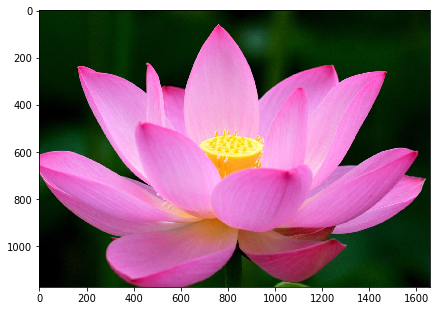

In [409]:
img =sal_crop
plt.imshow(img)

In [410]:
img_prep = img_preprocess(img, expand=True)
test_fea = pred_model.predict(img_prep) 
test_fea.shape

(1, 128)

In [411]:
f_dists, f_ids = flower_index.search(test_fea, k=7)
print(f_dists[0])
print(f_ids[0])
result_ids = f_ids[0][1:]

[171.39777 194.8281  197.11624 210.90167 218.13751 220.89606 226.0192 ]
[4813 4767 4799 4736 4733 4828 4728]


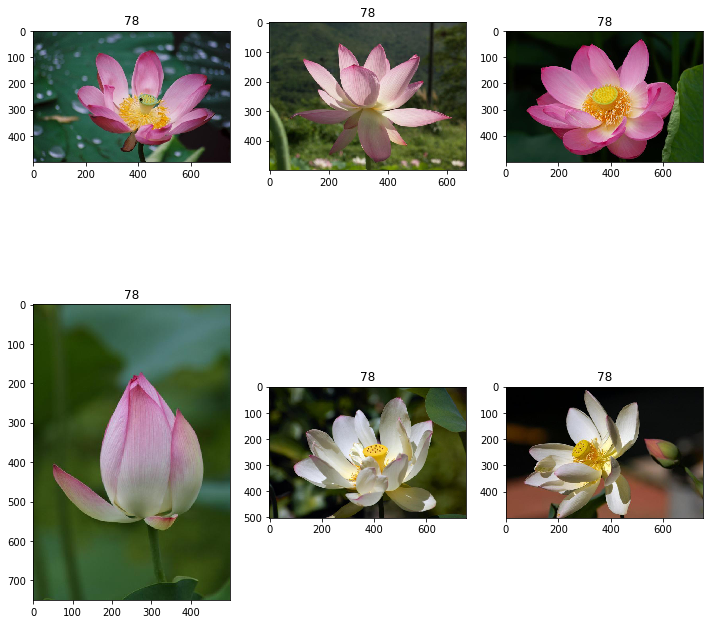

In [412]:
show_imgs(result_ids)

## Evaluating Result

In [413]:
def img_preprocess_2(img_fp, img_size=(384, 384), expand=True):
    img = cv2.imread(img_fp)[:, :, ::-1]
    img = cv2.resize(img, img_size)

    # normalize image
    img = norm_mean_std(img)

    if expand:
        img = np.expand_dims(img, axis=0)
    
    return img

In [414]:
def norm_embs(embs):
    embs /= np.linalg.norm(embs, axis=1, keepdims=True)
    return embs

In [415]:
train_embs = []
for img_fp in tqdm_notebook(train_img_fps):
    img = img_preprocess_2(img_fp, expand=True)
    emb = model.predict(img)
    train_embs.append(emb)
train_embs = np.vstack(train_embs)

In [416]:
X_test = np.array([img_preprocess_2(img_fp, expand=False) for img_fp in tqdm_notebook(test_img_fps)])

In [417]:
X_test.shape

(819, 384, 384, 3)

In [418]:
test_embs = model.predict(X_test)

In [420]:
train_embs.shape, test_embs.shape

((6552, 102), (819, 102))

In [421]:
test_embs = norm_embs(test_embs)
train_embs = norm_embs(train_embs)

In [422]:
from scipy.spatial.distance import cdist

In [423]:
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l,p in zip(labels, predictions)])

In [424]:
def total_metrics(train_embs, train_labels, test_embs, test_labels, top_k=5):
    topk_correct = 0
    mapk = []
    for emb, label in zip(test_embs, test_labels):
        dists = cdist(np.expand_dims(emb, axis=0), train_embs, metric='euclidean')[0]
        min_dist_indexes = dists.argsort()[:top_k]
        pred_labels = train_labels[min_dist_indexes]
        mapk.append(map_per_image(str(label), list(map(str, pred_labels))))

        if label in pred_labels:
            topk_correct += 1
    
    topk_value = topk_correct / test_embs.shape[0]
    mapk = np.mean(mapk)
    print(">>> Top{} acc: {:.4f}".format(top_k, topk_value))
    print(">>> Map@{}: {:.4f}".format(top_k, mapk))
    
    return topk_value, mapk

In [426]:
total_metrics(train_embs, train_labels, test_embs, test_labels, top_k=1);
total_metrics(train_embs, train_labels, test_embs, test_labels, top_k=5);

>>> Top1 acc: 0.7705
>>> Map@1: 0.7705
>>> Top5 acc: 0.8596
>>> Map@5: 0.8042
